In [2]:
import tensorflow as tf
from sklearn.datasets import load_iris
import pandas as pd
import numpy as np


In [3]:
def getboxes(contours,orig):
    boxes = []
    centers = []
    for contour in contours:
        box = cv2.minAreaRect(contour)
        box = cv2.cv.BoxPoints(box) if imutils.is_cv2() else cv2.boxPoints(box)
        box = np.array(box, dtype="int")
        (tl, tr, br, bl) = box
        if (dist.euclidean(tl, bl)) > 0 and (dist.euclidean(tl, tr)) > 0:
            boxes.append(box)
    return boxes

In [4]:
image_size=(120,120)
# code={"EOSINOPHIL":0,"LYMPHOCYTE":1,"MONOCYTE":2,"NEUTROPHIL":3}
# def getcode(n):
#     if type(n)==str:
#         for x,y in code.items():
#             if n==x:
#                 return y 
#     else:
#         for x,y in code.items():
#             if n==y:
#                 return x

In [5]:
def findedges(image):
    gray = cv2.GaussianBlur(image, (1, 1), 0)
    edged = cv2.Canny(gray, 100, 400)
    edged = cv2.dilate(edged, None, iterations=1)
    edged = cv2.erode(edged, None, iterations=1)
    return edged

In [6]:
def getimageconturs(edged):
    contours = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = imutils.grab_contours(contours)
    contours = sorted(contours, key=lambda x: cv2.contourArea(x))
    return contours

['/home/hisuh/dt/dataset2-master/images/TEST/NEUTROPHIL//_0_7022.jpeg']


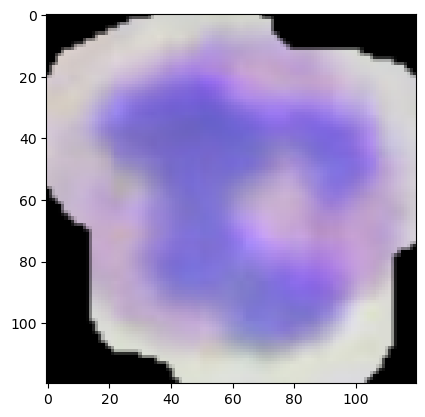

In [7]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial import distance as dist
import os
import cv2
import glob as gb
from skimage.filters import gaussian
from skimage.morphology import dilation,erosion
from skimage.feature import canny
from skimage.measure import find_contours
import imutils
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

current_directory = os.getcwd()
datasets= current_directory + "/dataset2-master/images/TEST/NEUTROPHIL/"


files =gb.glob(pathname=str(datasets + "/_0_7022.jpeg"))
print(files)
images = []

for file in files:
    image = cv2.imread(file)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                
    # add padding to the image to better detect cell at the edge
    image = cv2.copyMakeBorder(image,10,10,10,10,cv2.BORDER_CONSTANT,value=[198, 203, 208])
                
    #thresholding the image to get the target cell
    image1 = cv2.inRange(image,(80, 80, 180),(180, 170, 245))
                
    # openning errosion then dilation
    kernel = np.ones((3, 3), np.uint8)
    kernel1 = np.ones((5, 5), np.uint8)
    img_erosion = cv2.erode(image1, kernel, iterations=2)
    image1 = cv2.dilate(img_erosion, kernel1, iterations=5)
                
    #detecting the blood cell
    edgedImage = findedges(image1)
    edgedContours = getimageconturs(edgedImage)
    edgedBoxes =  getboxes(edgedContours, image.copy())
    if len(edgedBoxes)==0:
        count +=1
        continue
    # get the large box and get its cordinate
    last = edgedBoxes[-1]
    max_x = int(max(last[:,0]))
    min_x = int( min(last[:,0]))
    max_y = int(max(last[:,1]))
    min_y = int(min(last[:,1]))
                
    # draw the contour and fill it 
    mask = np.zeros_like(image)
    cv2.drawContours(mask, edgedContours, len(edgedContours)-1, (255,255,255), -1) 
                
    # any pixel but the pixels inside the contour is zero
    image[mask==0] = 0
                
    # extract th blood cell
    image = image[min_y:max_y, min_x:max_x]

    if (np.size(image)==0):
        count +=1
        continue
    # resize th image
    image = cv2.resize(image, image_size)
    images.append(image)
    
    plt.imshow(image)
    plt.show()
    
images = np.array(images, dtype = 'float32')

# print(image.shape)

# img = cv2.resize(image,(120,120))
# img = img.reshape(120,120,3)

# print(image.shape)
# plt.imshow(img)
# plt.show()

    

In [9]:
# for transformer if run just cnn custom, leave to run
#!pip install -U tensorflow-addons
import tensorflow_addons as tfa
from keras import layers, models

class Patches(layers.Layer):
    def __init__(self, patch_size, **kwargs):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def get_config(self):
        config = super().get_config().copy()
        config.update(
            {
                "input_shape": input_shape,
                "patch_size": patch_size,
                "num_patches": num_patches,
                "projection_dim": projection_dim,
                "num_heads": num_heads,
                "transformer_units": transformer_units,
                "transformer_layers": transformer_layers,
                "mlp_head_units": mlp_head_units,
            }
        )
        return config
    
    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim, **kwargs):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )
    def get_config(self):
        config = super().get_config().copy()
        config.update(
            {
                "input_shape": input_shape,
                "patch_size": patch_size,
                "num_patches": num_patches,
                "projection_dim": projection_dim,
                "num_heads": num_heads,
                "transformer_units": transformer_units,
                "transformer_layers": transformer_layers,
                "mlp_head_units": mlp_head_units,
            }
        )
        return config
    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

In [11]:
# new_model = tf.keras.models.load_model('result_vi.h5')
# new_model = keras.models.load_model('result_vi.h5', custom_objects={'CustomModel': CustomModel})
# !pip install keras-self-attention

from keras_self_attention import SeqSelfAttention
# model2 = keras.models.load_model('result_vi.h5',custom_objects={'Patches':Patches, 'PatchEncoder':PatchEncoder})
model2 = keras.models.load_model('result_vgg90ab.h5',custom_objects={'Patches':Patches, 'PatchEncoder':PatchEncoder})

# y_predict =  new_model.predict(images)

y_prob = model2.predict(images) 
predicted = y_prob.argmax(axis=-1)
a = []
for i in y_prob:
    for j in i:
        t = '{:.9f}'.format(j)
        a.append(t)
        
print(a)

2022-12-08 15:10:21.945574: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8600


['0.000000000', '0.000000000', '0.000000000', '1.000000000']
